# Borrowing of strength in Bayesian hierarchical model
We consider the problem of estimating the average number of patients admitted to
ER per day from various hospitals across a city. A Bayesian hierarchical model
(BHM) allows us to partially pool information across hospitals, reducing
variance in small-sample groups and leveraging strength across hospitals to
estimate the population-level parameters. Here, we investigate a Poisson-
lognormal model.

(a) Generate a dataset where the logarithm of the expected number of admissions
    per day for hospital $j$, $ln \lambda_j$, comes from a Normal distribution:

$$ ln \lambda_j \sim \mathcal{N}(\mu_0,\,\sigma_0^{2}), \text{ for } j = 1, ..., J $$

The admission counts data for each hospital for day $i$ follow a Poisson
distribution:

$$ y_{ij} \mid \lambda_j \sim \text{Poisson}(\lambda_j), \text{ for } i = 1, ..., n_j $$

where each hospital $j$ has a different reporting frequency, which leads to
different $n_j$ for each. To model this, you may draw $n_j$ randomly with equal
probability from the set $\{52, 24, 12\}$, representing respectively weekly,
twice a month and monthly reporting. Do this once, and keep $n_j$ fixed,
treating it as known, throughout the exercise.

The DAG for this model is shown in the figure.

![Figure 1: DAG for hospital admission BHM](./figure_1.pdf)

Since $\mu_0$ is the typical log-rate
across hospitals, we may choose for its prior
$$Pr(\mu_0) = \mathcal{N}(\log m, s^2)$$

where $m$ is a plausible choice for the median number of admissions/day, and s
controls its spread. Since $\sigma_0$ controls the variability across hospitals,
a prior choice that tends to reinforce shrinkage is $Pr(\sigma_0) = \exp(\tau)$.

Fix $m$, $s^2$, $\tau$ to sensible values, and use an MCMC algorithm of your
choice to sample from the model and produce posterior distribution on
$\{\lambda_j\}^J_{j=1}, \mu _0, \sigma _0$ (a sensible choice might be $J = 10$
hospitals).

In [25]:
from typing import List, Callable, Tuple

import corner
import emcee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.special import gammaln
from scipy.stats import pearsonr

np.random.seed(42)

In [2]:
J = 10
reporting_frequency = np.random.choice(
    [54, 24, 12],
    J
)

print(f"We have {J} hospitals reporting admission data.")
for j in range(J):
    print(
        f"- Hospital number {j + 1:2} reports admission data "
        f"{reporting_frequency[j]} times a year."
    )

We have 10 hospitals reporting admission data.
- Hospital number  1 reports admission data 12 times a year.
- Hospital number  2 reports admission data 54 times a year.
- Hospital number  3 reports admission data 12 times a year.
- Hospital number  4 reports admission data 12 times a year.
- Hospital number  5 reports admission data 54 times a year.
- Hospital number  6 reports admission data 54 times a year.
- Hospital number  7 reports admission data 12 times a year.
- Hospital number  8 reports admission data 24 times a year.
- Hospital number  9 reports admission data 12 times a year.
- Hospital number 10 reports admission data 12 times a year.


In [3]:
def get_expected_admission_counts(mu: float, sigma: float, size: int):
    """Get expected number of admissions to a hospital at 'size' time points.
    
    The log of the admission rate comes from a normal distribution with mean
        'mu' and standard deviation 'sigma'.
    The expected number of admissions comes from a Poisson distribution with
        parameter 'admission_rate'.
    From the same Poisson distribution, 'size' time points will be sampled.
    """
    log_admission_rate = np.random.normal(
        mu, sigma
    )
    admission_rate = np.exp(log_admission_rate)
    admission_counts = np.random.poisson(
        admission_rate, size=size
    )
    return admission_counts, admission_rate

In [4]:
def get_admission_count_matrix(
    mu: float, sigma: float
) -> Tuple[pd.DataFrame, List[float]]:
    data = {}
    true_lambdas = []
    total_array_length = max(reporting_frequency)
    for j in range(J):  # For each hospital
        data_array_length = reporting_frequency[j]
        admission_records, admission_rate = get_expected_admission_counts(
            mu, sigma, size=data_array_length
        )
        true_lambdas.append(admission_rate)
        padding = np.full(total_array_length - data_array_length, 0, dtype=int)
        admission_records = np.concatenate([
            admission_records,
            padding
        ])
        data[f"Hospital {j+1}"] = admission_records
    data = pd.DataFrame(data)
    data.index.name = "Time point"
    return data.transpose(), true_lambdas

- Prior for $\mu_0$: we choose $m$ (typical log-rate across hospitals) and $s$
(a measure of the spread of $m$); $Pr(\mu_0) = \mathcal{N}(\log m, s^2)$.
- Prior for $\sigma_0$: $Pr(\sigma_0) = \text{Exponential}(\tau)$

In [5]:
m = 85
s = 0.4
tau = 0.1

In [6]:
true_mu_0 = np.random.normal(np.log(m), s)
true_sigma_0 = np.random.exponential(tau)

df, true_lambdas = get_admission_count_matrix(mu=true_mu_0, sigma=true_sigma_0)

print(df)

Time point    0    1    2    3    4    5    6    7    8    9   ...   44   45  \
Hospital 1   149  147  161  152  144  155  171  161  146  173  ...    0    0   
Hospital 2   180  166  160  178  182  147  153  151  154  161  ...  150  152   
Hospital 3   174  147  163  149  146  156  144  142  177  166  ...    0    0   
Hospital 4   154  178  170  138  178  165  145  167  148  149  ...    0    0   
Hospital 5   163  155  156  165  160  160  169  155  183  175  ...  143  168   
Hospital 6   163  162  165  161  156  180  136  167  153  151  ...  142  165   
Hospital 7   167  165  179  178  164  147  154  161  173  146  ...    0    0   
Hospital 8   145  155  174  159  151  176  162  150  164  166  ...    0    0   
Hospital 9   183  150  153  150  143  145  165  154  159  146  ...    0    0   
Hospital 10  154  167  171  138  181  151  169  148  159  154  ...    0    0   

Time point    46   47   48   49   50   51   52   53  
Hospital 1     0    0    0    0    0    0    0    0  
Hospital 2 

We can use AIES (ensemble samplers with affine invariance), introduced by
Goodman and Weare in 2010 and implemented by the `emcee` python package, to
sample from the joint posterior without analytically deriving it.

We have to write a function that takes in all hyper-parameters (both fixed and
unknown) and returns the posterior value for those parameters; we will then
construct an `emcee.EnsembleSampler` (giving the number of unknown parameters
and the known ones) and we will finally run MCMC for a certain number of steps.
The sampler will return tuples of sampled parameters.

For analytical convenience, we will use $\ln(Posterior)$, $\ln(\text{Prior})$
and $\ln(\mathcal{L})$.

In [7]:
def log_posterior(parameters,
                  m: float, s: float, tau: float,
                  J: int, df: pd.DataFrame):
    # lambda_j is an array of length J with the admission rate for each hospital
    mu_0, sigma_0, *lambdas = parameters
    # Check parameters that have to be strictly positive
    if sigma_0 <= 0:  # Standard deviation of a Normal distribution
        return -np.inf
    if any(l <= 0 for l in lambdas):  # Frequency of a Poisson distribution
        return -np.inf
    log_prior = 0.0
    # Prior for 'mu_0' (normally distributed, parameters 'm' and 's')
    log_prior += (
        -0.5 * np.log(2 * np.pi * s**2)
        -0.5 * ((mu_0 - np.log(m))**2) / s**2
    )
    # Prior for 'sigma_0' (exponentially distributed, parameter 'tau')
    log_prior += (
         np.log(tau) - tau * sigma_0
    )
    log_likelihood = 0.0
    # Prior for 'lambdas' (each log-normally distributed, parameters 'mu_0', 'sigma_0')
    # and likelihood of 'observed_admissions' (Poisson distributed, parameter 'lambdas[j]')
    # We only iterate once over range(J) for the sake of efficiency
    for j in range(J):
        log_prior += (
            -np.log(lambdas[j] * sigma_0 * np.sqrt(2 * np.pi))
            - ((np.log(lambdas[j]) - mu_0)**2) / (2 * sigma_0**2)
        )
        # Get the observed admission counts for hospital j,
        #   and cast it to a numpy array for efficiency
        # This is equivalent to (but faster than) a for loop
        #   for i in range(reporting_frequency[j]):
        #       reporting_frequency = df.iloc[j, i]
        #       log_likelihood += (...)
        observed_admissions = df.iloc[j,:reporting_frequency[j]].to_numpy()
        log_likelihood += np.sum(
            observed_admissions * np.log(lambdas[j])
            - lambdas[j]
            - gammaln(observed_admissions+1)
        )
    return log_prior + log_likelihood

In [8]:
def get_samples_from_full_bhm(initial_mu_0: float, initial_sigma_0: float,
                              initial_lambdas: List[float],
                              log_posterior: Callable,
                              m: float, s: float, tau: float,
                              J: int, df: pd.DataFrame):
      # Data: observed_admissions (from previous synthetic data generation)
      # Assuming observed_admissions is a pandas df (J * max(reporting_frequency))

      # Number of dimensions and walkers
      ndim = 2 + J  # [mu_0, sigma_0, lambda_1, ..., lambda_J]
      num_walkers = 32

      # Initial guess for parameters
      initial_guess = [
            initial_mu_0,
            initial_sigma_0,
            *initial_lambdas
      ]

      # Initialize walkers in a small ball around the initial guess
      pos = initial_guess + 1e-4 * np.random.randn(num_walkers, ndim)

      # Create the sampler
      sampler = emcee.EnsembleSampler(
            num_walkers, ndim, log_posterior,
            args=(m, s, tau, J, df)
      )

      # Run MCMC
      nsteps = 5000
      sampler.run_mcmc(pos, nsteps, progress=True)

      # Get one sample every 'thin' steps, discarding the burn-in (first 'discard' steps)
      return sampler.get_chain(discard=1000, thin=10, flat=True)


samples = get_samples_from_full_bhm(
      initial_mu_0=true_mu_0 * 0.9, initial_sigma_0=true_sigma_0 * 1.1,
      initial_lambdas=[
            lambda_j * (0.9 + 0.2 * np.random.random())
            for lambda_j in true_lambdas
      ],
      log_posterior=log_posterior,
      m=m, s=s, tau=tau, J=J, df=df
)

100%|██████████| 5000/5000 [04:03<00:00, 20.51it/s]


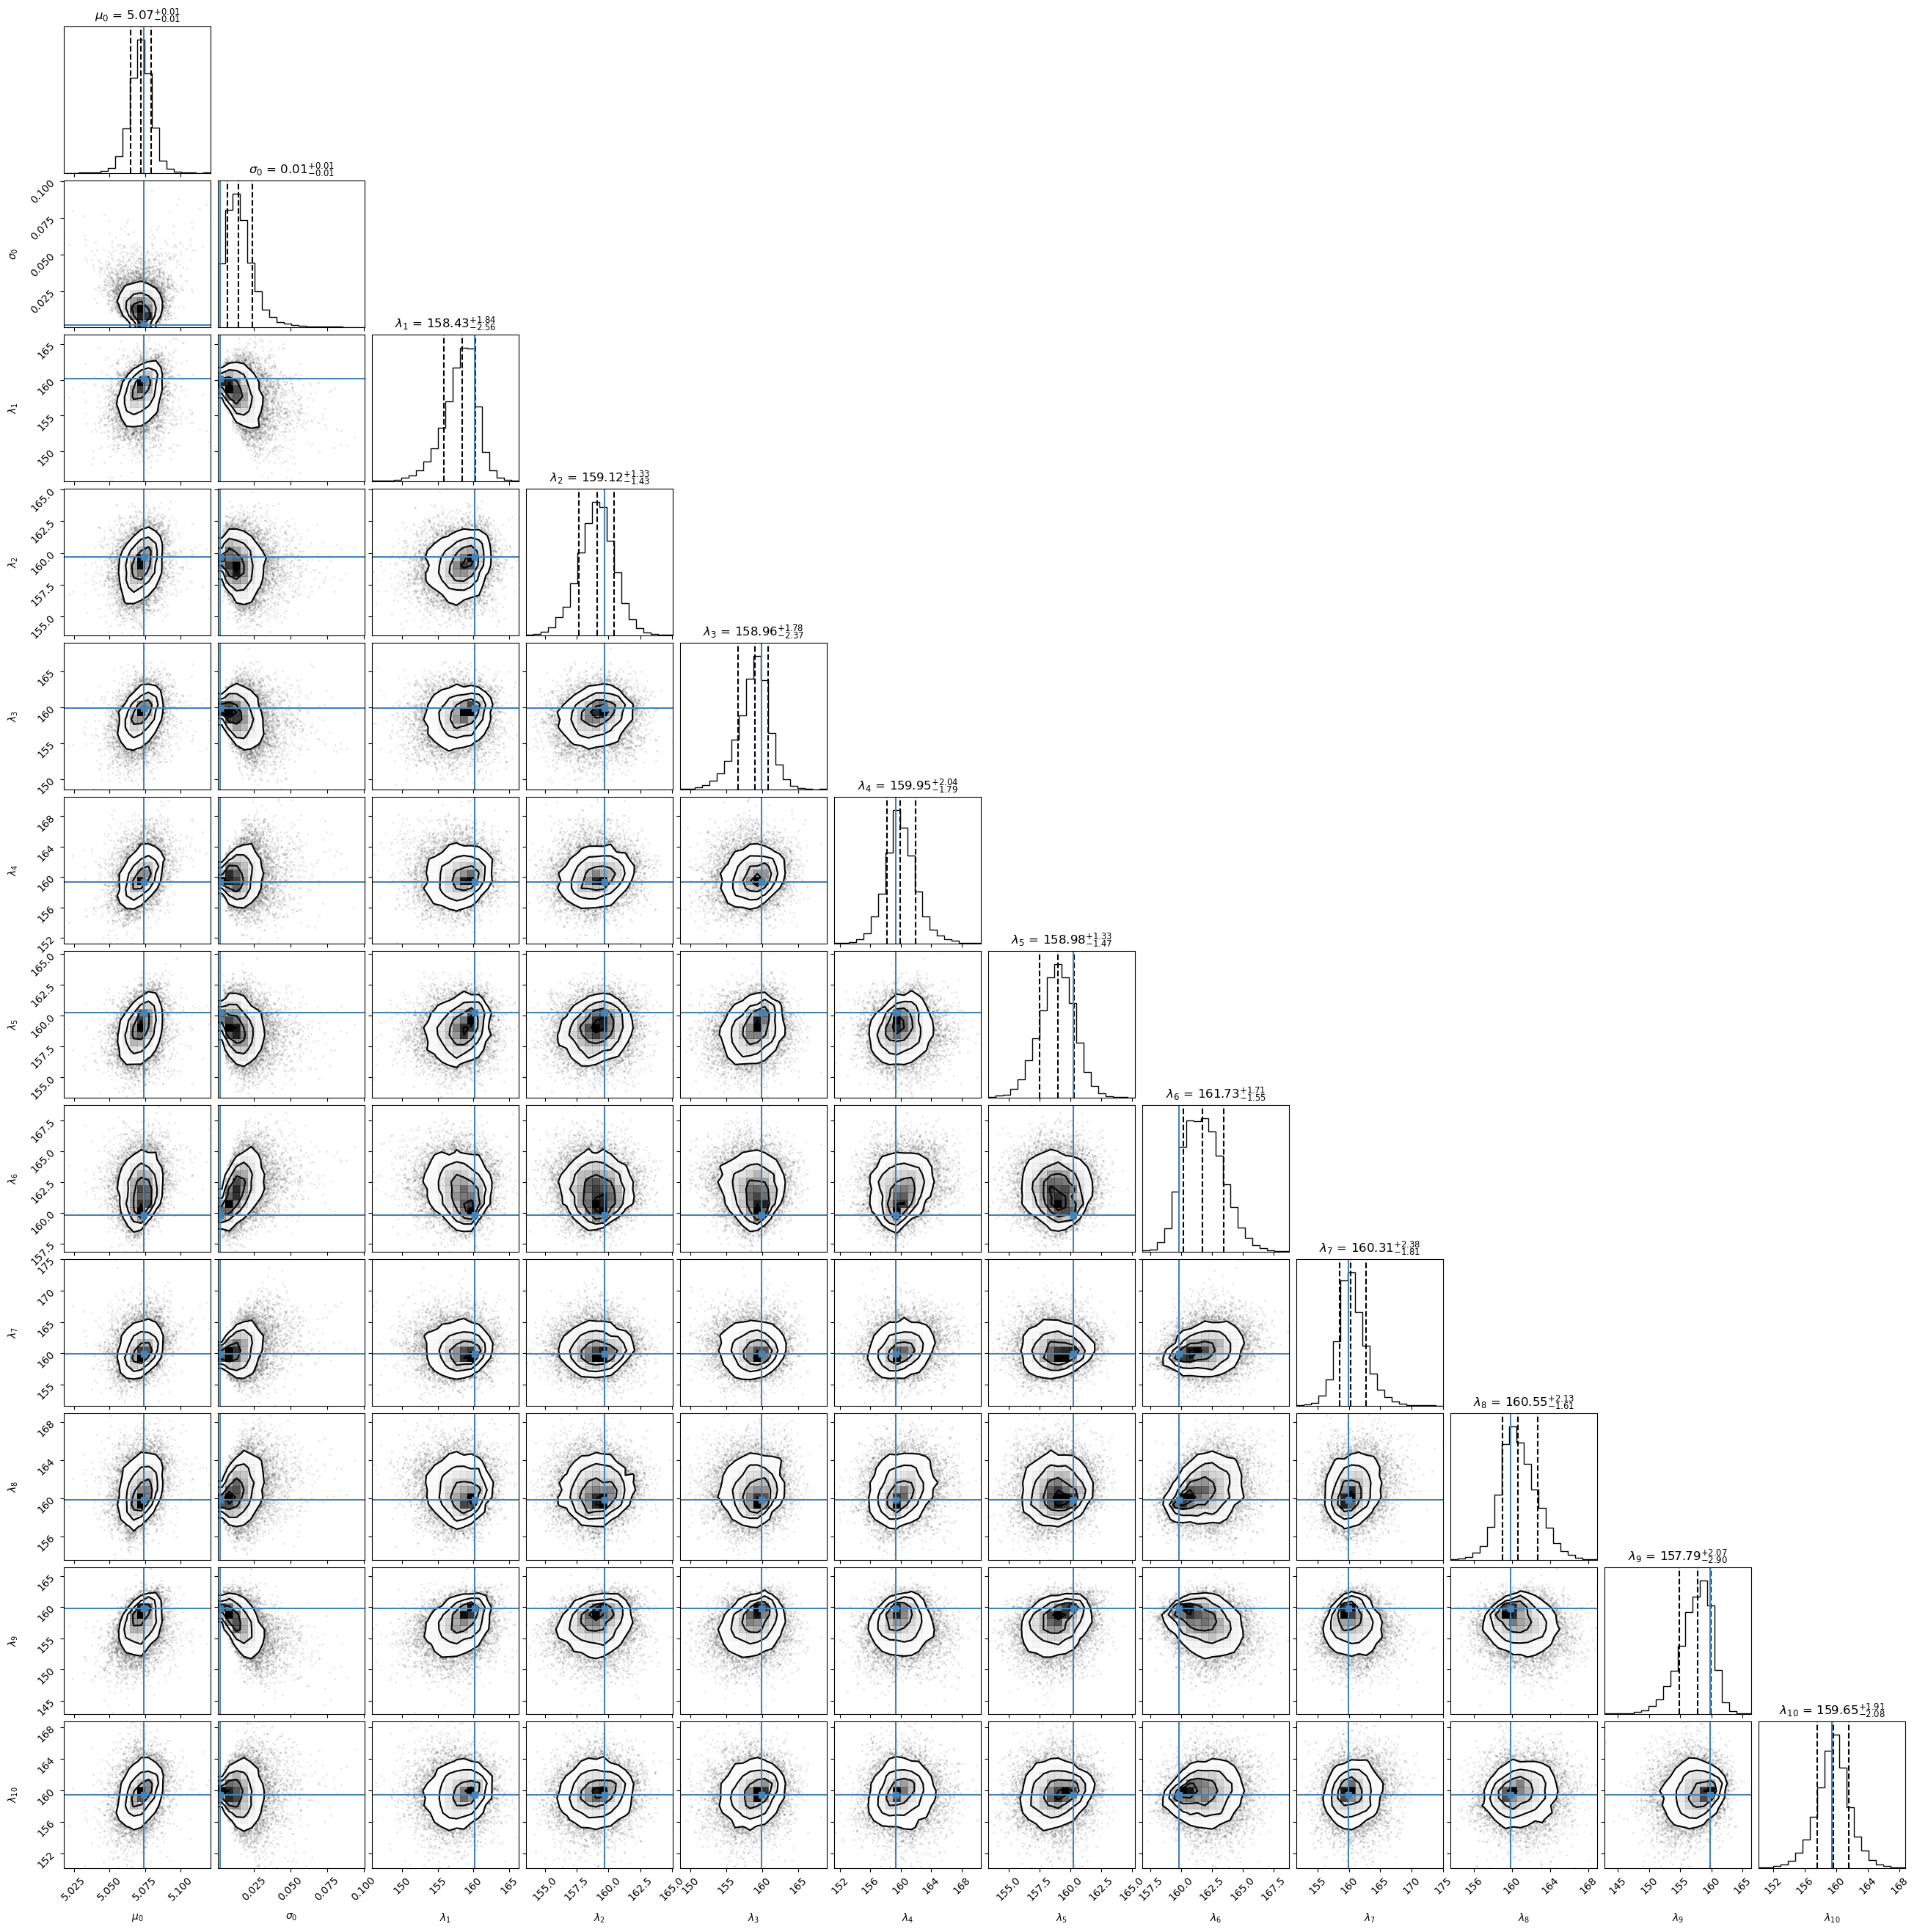

In [9]:
# Labels and true values
labels = [r'$\mu_0$', r'$\sigma_0$', *[rf'$\lambda_{{{j + 1}}}$' for j in range(J)]]
truths = [true_mu_0, true_sigma_0, *true_lambdas]

# Create a corner plot
fig = corner.corner(
    samples,
    labels=labels,
    truths=truths,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12}
)
plt.show()

____

(b) Determine the marginal posterior distribution for the admission rate for
each hospital, and compare it with the posterior estimate in a model with no
pooling (i.e., where each hospital’s rate is inferred exclusively from its
observed counts, i.e. $\ln \lambda_j \sim \mathcal{N} (\mu_0, \sigma^2_0)$ and
the same priors as above, and the posterior for hospital j comes exclusively
from its own data). Check that the posterior means for hospitals with a smaller
number of records (i.e., $n_j = 12$) exhibit stronger shrinkage towards the
global mean, thus demonstrating borrowing of strength, and typically have 68%
HPD credible intervals that are shorter than in the pooling model. You may use a
violin plot to make this comparison.

#### With pooling

In [10]:
rows = []

for j in range(J):
    mu_0_j = samples[:, 0]
    sigma_0_j = samples[:, 1]
    lambda_samples_j = np.log(samples[:, 2 + j])
    lower, upper = np.percentile(lambda_samples_j, [16, 84])
    rows.append({
        "Hospital": j + 1,
        "Reporting frequency": reporting_frequency[j],
        "log lambda 16th percentile": lower,
        "log lambda 84th percentile": upper,
        "HPD width (68%)": upper - lower,
        "mu_0": np.mean(mu_0_j),
        "sigma_0": np.mean(sigma_0_j)
    })

temp = pd.DataFrame(rows)
temp = pd.DataFrame(rows).set_index("Hospital")
print(temp)


          Reporting frequency  log lambda 16th percentile  \
Hospital                                                    
1                          12                    5.048979   
2                          54                    5.060622   
3                          12                    5.053617   
4                          12                    5.063582   
5                          54                    5.059486   
6                          54                    5.076310   
7                          12                    5.065790   
8                          24                    5.068508   
9                          12                    5.042735   
10                         12                    5.059849   

          log lambda 84th percentile  HPD width (68%)      mu_0   sigma_0  
Hospital                                                                   
1                           5.076839         0.027860  5.072097  0.015922  
2                           5.077944   

In [11]:
x = temp["Reporting frequency"].to_numpy()
y = temp["HPD width (68%)"].to_numpy()

r, p_value = pearsonr(x, y)
r_squared = r**2

print(f"Pearson r = {r:.3f}")
print(f"R^2 = {r_squared:.3f}")
print(f"p-value = {p_value:.3e}")


Pearson r = -0.878
R^2 = 0.771
p-value = 8.381e-04


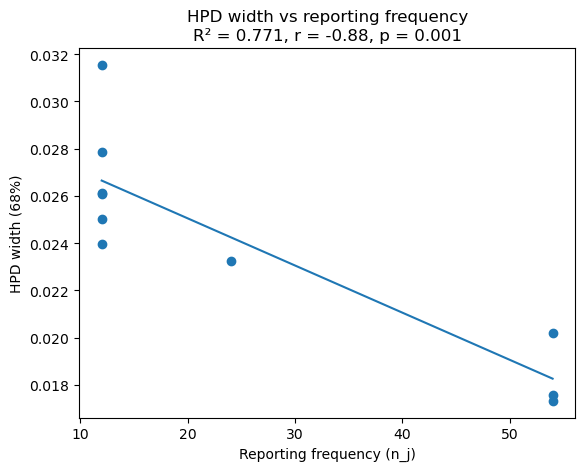

In [12]:
# Fit least-squares line
slope, intercept = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept

plt.figure()
plt.scatter(x, y)
plt.plot(x_line, y_line)
plt.xlabel("Reporting frequency (n_j)")
plt.ylabel("HPD width (68%)")
plt.title(
    f"HPD width vs reporting frequency\n"
    f"R² = {r_squared:.3f}, r = {r:.2f}, p = {p_value:.3f}"
)
plt.show()


#### Without pooling

In [13]:
mu_fixed = np.log(m)
sigma_fixed = s


def log_posterior_without_pooling(parameters: np.ndarray,
                                  mu_0: float, sigma_0: float,
                                  j: int, df: pd.DataFrame):
    lambda_j, *_ = parameters
    if lambda_j <= 0:
        return -np.inf
    # Prior on 'lambda_j' (log-normally distributed, parameters 'mu_0' and 'sigma_0')
    log_prior = (
        -np.log(lambda_j * sigma_0 * np.sqrt(2 * np.pi))
        - (np.log(lambda_j) - mu_0)**2 / (2 * sigma_0**2)
    )
    observed_admissions = df.iloc[j,:reporting_frequency[j]].to_numpy()
    # Likelihood: Poisson
    log_likelihood = np.sum(
        observed_admissions * np.log(lambda_j)
        - lambda_j
        - gammaln(observed_admissions + 1)
    )

    return log_prior + log_likelihood


def get_samples_without_pooling(initial_lambdas: List[float],
                                log_posterior_without_pooling: Callable,
                                mu_fixed: float, sigma_fixed: float,
                                J: int, df: pd.DataFrame):
    samples_without_pooling = {}
    for j in range(J):
        # Number of dimensions and walkers
        ndim = 1  # Only lambda_j
        num_walkers = 32

        # Initial guess for parameters
        initial_guess = [
            initial_lambdas[j]
        ]

        # Initialize walkers in a small ball around the initial guess
        pos = initial_guess + 1e-4 * np.random.randn(num_walkers, ndim)

        # Create the sampler
        sampler = emcee.EnsembleSampler(
            num_walkers, ndim, log_posterior_without_pooling,
            args=(mu_fixed, sigma_fixed, j, df)
        )

        # Run MCMC
        nsteps = 3000
        sampler.run_mcmc(pos, nsteps, progress=True)

        # Get one sample every 'thin' steps, discarding the burn-in (first 'discard' steps)
        samples_without_pooling[j] = sampler.get_chain(discard=1000, thin=10, flat=True)
    return samples_without_pooling


samples_without_pooling = get_samples_without_pooling(
    initial_lambdas=[
        lambda_j * (0.9 + 0.2 * np.random.random())
        for lambda_j in true_lambdas
      ],
    log_posterior_without_pooling=log_posterior_without_pooling,
    mu_fixed=mu_fixed, sigma_fixed=sigma_fixed,
    J=J, df=df
)

100%|██████████| 3000/3000 [00:21<00:00, 138.94it/s]


In [14]:
rows = []

for j in range(J):
    swp = samples_without_pooling[j]
    lambda_samples_j = np.log(swp[:, 0])
    lower, upper = np.percentile(lambda_samples_j, [16, 84])
    rows.append({
        "Hospital": j + 1,
        "Reporting frequency": reporting_frequency[j],
        "log lambda 16th percentile": lower,
        "log lambda 84th percentile": upper,
        "HPD width (68%)": upper - lower,
        "mu_0": np.mean(mu_fixed),
        "sigma_0": np.mean(sigma_fixed)
    })

temp = pd.DataFrame(rows)
temp = pd.DataFrame(rows).set_index("Hospital")
print(temp)


          Reporting frequency  log lambda 16th percentile  \
Hospital                                                    
1                          12                    5.017071   
2                          54                    5.057248   
3                          12                    5.027429   
4                          12                    5.057141   
5                          54                    5.054694   
6                          54                    5.085284   
7                          12                    5.070768   
8                          24                    5.072616   
9                          12                    4.999103   
10                         12                    5.044466   

          log lambda 84th percentile  HPD width (68%)      mu_0  sigma_0  
Hospital                                                                  
1                           5.063500         0.046429  4.442651      0.4  
2                           5.079072      

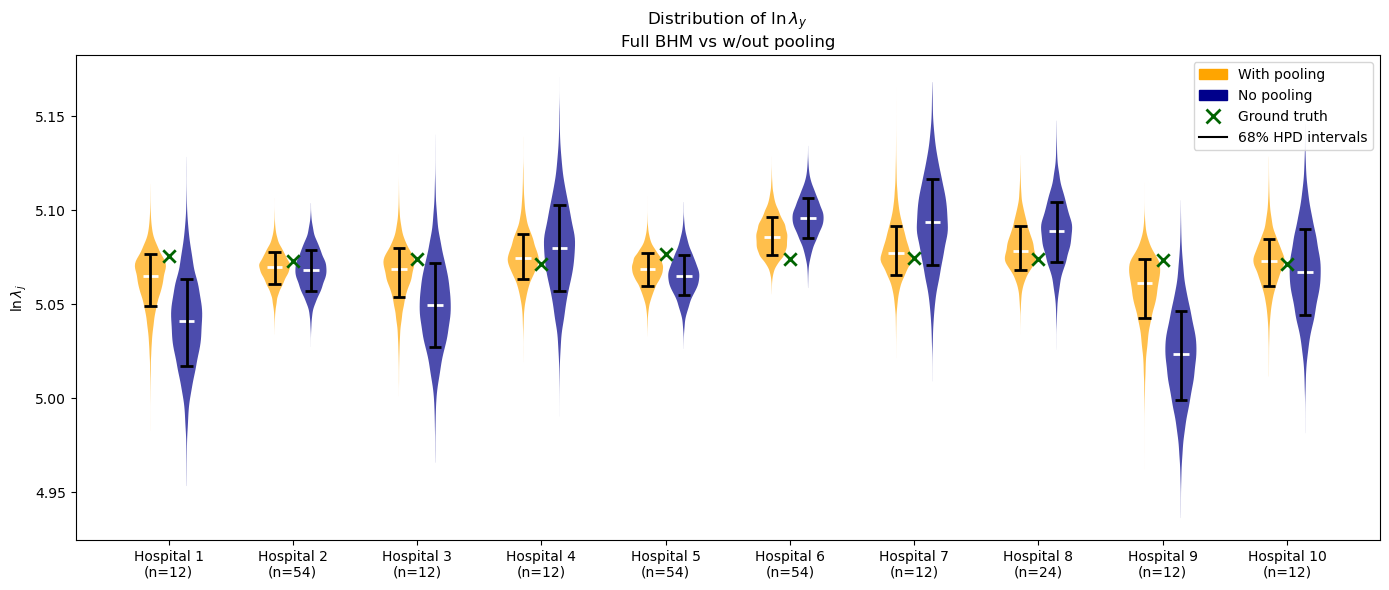

In [34]:
data = []
positions = []
groups = []

pos, offset, step = 1.0, 0.35, 1.2

for j in range(J):
    # With pooling
    data.append(np.log(samples[:, 2 + j]))
    positions.append(pos)
    groups.append("bhm")
    # Without pooling
    data.append(np.log(samples_without_pooling[j][:, 0]))
    positions.append(pos + offset)
    groups.append("nopool")
    pos += step

plt.figure(figsize=(14, 6))

vp = plt.violinplot(
    data,
    positions=positions,
    widths=0.3,
    showmeans=False,
    showmedians=True,
    showextrema=False
)

# Color each violin plot according to group (with or without pooling)
for body, group in zip(vp["bodies"], groups):
    body.set_facecolor(
        {
            "bhm": "orange",
            "nopool": "darkblue"
        }[group]
    )
    body.set_alpha(0.7)

vp["cmedians"].set_color("white")
vp["cmedians"].set_alpha(1.0)
vp["cmedians"].set_linewidth(2.0)

# Add ground truth
x_true_lambdas = [1 + step * j + offset / 2 for j in range(J)]
y_true_lambdas = np.log(true_lambdas)
plt.scatter(
    x_true_lambdas, y_true_lambdas,
    color="darkgreen", marker="x",
    s=80, linewidths=2,
    zorder=100000,
    label="Ground truth"
)

# Add 86% HPD intervals
cap_width = 0.06
for i, x in enumerate(positions):
    lower = np.quantile(data[i], 0.16)
    higher = np.quantile(data[i], 0.84)
    plt.hlines(
        y=[lower, higher],
        xmin=x - cap_width,
        xmax=x + cap_width,
        color="black",
        linewidth=2,
        zorder=10
    )
    plt.vlines(
        x=x,
        ymin=lower,
        ymax=higher,
        color="black",
        linewidth=2,
        zorder=10
    )

# Set axes labels and plot title
plt.xticks(
    [1 + step * j + offset/2 for j in range(J)],
    [f"Hospital {j+1}\n(n={reporting_frequency[j]})" for j in range(J)]
)
plt.ylabel(r"$\ln \lambda_j$")
plt.title(r"Distribution of $\ln \lambda_y$""\n"r"Full BHM vs w/out pooling")

plt.legend(
    handles=[
        Patch(color="orange", label="With pooling"),
        Patch(color="darkblue", label="No pooling"),
        Line2D(
            [0], [0],
            marker="x",
            color="darkgreen",
            linestyle="None",
            markersize=10,
            markeredgewidth=2,
            label="Ground truth"
        ),
        Line2D(
            [0], [0],
            color="black",
            markersize=10,
            markeredgewidth=2,
            label="68% HPD intervals"
        )
    ],
    loc="upper right"
)

plt.tight_layout()
plt.show()


___

(c) Consider the prior predictive distribution for possible data within the BHM:

$$ Pr( y_{ij} \mid priors) = \int Pr ( y_{ij} \mid \lambda_j) Pr(\lambda_j \mid \mu_0, \sigma_0) Pr (\mu_0,\sigma_0) d \mu_0 d \sigma_0$$

and simulate from it predictions for the possible counts $y_{ij}$ from the model
(before you see any data). Evaluate the degree of shrinkage by using as metric
the average shrinkage in the standard deviation of the posterior with respect to
the no-pooling scenario, i.e.

$$ S = \frac {1} {J} \sum_{j=1}^{J}{1 - \frac{\text{std}_\text{BHM}(\ln \lambda_j \mid \bold y)}{\text{std}_\text{no pool}(\ln \lambda_j \mid \bold y)}}$$

where a smaller S corresponds to higher degree of shrinkage.

Determine which hyperparameter among $(m, s, \tau)$ has the most effect on the
degree of shrinkage, and tune each to avoid predictions that are too diffuse
(i.e., the predictive spread is unreasonably wide) or too narrow (i.e., the
predictive spread is over-constraining).

In [16]:
S = np.mean([
    1 - (
        np.std(np.log(samples[:, 2 + j]))
        / np.std(np.log(samples_without_pooling[j][:, 0]))
    )
    for j in range(J)
])

print(
    f"The degree of shrinkage S for m = {m}, s = {s}, tau = {tau} is: {S:.3f}"
)

The degree of shrinkage S for m = 85, s = 0.4, tau = 0.1 is: 0.291


In [17]:
m = 85
s = 0.4
tau = 0.1

def evaluate_degree_of_shrinkage(m, s, tau):
    print(
        f"Evaluating degree of shrinkage S for m = {m}, s = {s}, tau = {tau}..."
    )
    true_mu_0 = np.random.normal(np.log(m), s)
    true_sigma_0 = np.random.exponential(tau)
    df, true_lambdas = get_admission_count_matrix(
        mu=true_mu_0, sigma=true_sigma_0
    )
    initial_mu_0 = true_mu_0 * 0.9
    initial_sigma_0 = true_sigma_0 * 1.1
    initial_lambdas = [
        lambda_j * (0.9 + 0.2 * np.random.random())
        for lambda_j in true_lambdas
    ]
    # Samples from joint posterior (full BHM)
    samples_bhm = get_samples_from_full_bhm(
        initial_mu_0=initial_mu_0, initial_sigma_0=initial_sigma_0,
        initial_lambdas=initial_lambdas,
        log_posterior=log_posterior,
        m=m, s=s, tau=tau,
        J=J, df=df
    )
    # Samples from non-pooling model
    samples_without_pooling = get_samples_without_pooling(
        initial_lambdas=initial_lambdas,
        log_posterior_without_pooling=log_posterior_without_pooling,
        mu_fixed=initial_mu_0, sigma_fixed=initial_sigma_0,
        J=J, df=df
    )
    S = np.mean([
        1 - (
            np.std(np.log(samples_bhm[:, 2 + j]))
            / np.std(np.log(samples_without_pooling[j][:, 0]))
        )
        for j in range(J)
    ])
    print(
        f"The degree of shrinkage S for m = {m}, s = {s}, tau = {tau} is: {S:.3f}"
    )


evaluate_degree_of_shrinkage(m=(1.1 * m), s=s, tau=tau)
evaluate_degree_of_shrinkage(m=m, s=(1.1 * s), tau=tau)
evaluate_degree_of_shrinkage(m=m, s=s, tau=(1.1 * tau))

Evaluating degree of shrinkage S for m = 93.50000000000001, s = 0.4, tau = 0.1...


100%|██████████| 3000/3000 [00:15<00:00, 193.01it/s]


The degree of shrinkage S for m = 93.50000000000001, s = 0.4, tau = 0.1 is: 0.015
Evaluating degree of shrinkage S for m = 85, s = 0.44000000000000006, tau = 0.1...


100%|██████████| 3000/3000 [00:17<00:00, 171.85it/s]


The degree of shrinkage S for m = 85, s = 0.44000000000000006, tau = 0.1 is: 0.021
Evaluating degree of shrinkage S for m = 85, s = 0.4, tau = 0.11000000000000001...


100%|██████████| 3000/3000 [00:16<00:00, 178.59it/s]

The degree of shrinkage S for m = 85, s = 0.4, tau = 0.11000000000000001 is: -0.003


## Tentative interpretation of these results

The parameter that affects $S$ more is $\tau$, which controls the variability of
lambdas across hospitals. Therefore, the BHM is most useful when the sources
being pooled have similar values for the latent variables (in this case, smaller
$\tau$), which makes sense.

Also $s$ (the uncertainty about the population mean admission rate) affects $S$
(lower $s$ means more shrinkage).

$m$, the population mean admission rate, affects $S$ indirectly through
$\sigma_0$.

To support this conclusion, the following table reports the increase of each
parameter and the decrease in shrinkage it produced when comparing the full
hierarchical model with the model without pooling across hospitals.

The smallest change in parameters ($\tau + 0.01$) also produced the biggest
deterioration in BHM performance, supporting the hypothesis that $\tau$ is the
most influent parameter in determining the efficacy of borrowing of strength.

Parameter | 10% increase in parameter | $\Delta S$
| :-----: | :-----------------------: | :--------: |
m         | 8.5                       | 27.6%
s         | 0.04                      | 27.0%
$\tau$    | 0.01                      | 29.4%